## Installing the necessary libraries

In [1]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

     ---------------------------------------- 1.5/1.5 MB 561.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
     ---------------------------------------- 7.6/7.6 MB 85.0 kB/s eta 0:00:00
     ------------------------------------ 123.5/123.5 kB 315.6 kB/s eta 0:00:00
     ---------------------------------------- 7.7/7.7 MB 94.1 kB/s eta 0:00:00
  Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
     ---------------------------------------- 2.5/2.5 MB 140.8 kB/s eta 0:00:00
  Using cached PyYAML-6.0-cp311-cp311-win_amd64.whl (143 kB)
  Using cached QtPy-2.3.1-py3-none-any.whl (84 kB)
  Using cached PyQt5-5.15.9-cp37-abi3-win_amd64.whl (6.8 MB)
     -------------------------------

  DEPRECATION: wrapt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: tensorflow-gpu is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <mod

### Partition and Augmented Data

#### Import libraries

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

#### Limit GPU 

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

##Load an image into a the Pipeline

In [6]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [7]:
images.as_numpy_iterator().next()

b'data\\images\\44995f143b2d4e7da45875394939997b.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[121, 139, 143],
        [120, 138, 142],
        [120, 138, 142],
        ...,
        [136, 157, 162],
        [137, 158, 163],
        [137, 158, 163]],

       [[119, 137, 141],
        [119, 137, 141],
        [119, 137, 141],
        ...,
        [137, 158, 163],
        [137, 158, 163],
        [137, 158, 163]],

       [[119, 134, 139],
        [120, 135, 140],
        [121, 136, 141],
        ...,
        [137, 158, 163],
        [138, 159, 164],
        [138, 159, 164]],

       ...,

       [[103, 124, 127],
        [103, 124, 127],
        [102, 126, 128],
        ...,
        [ 95, 119, 119],
        [ 96, 120, 120],
        [ 96, 120, 120]],

       [[104, 125, 126],
        [104, 125, 126],
        [102, 126, 126],
        ...,
        [ 93, 117, 117],
        [ 94, 118, 118],
        [ 95, 119, 119]],

       [[104, 125, 126],
        [104, 125, 126],
        [102, 126, 126],
        ...,
        [ 92, 116, 116],
        [ 93, 117, 117],
        [ 94, 118, 118]]

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [12]:
## Let us view the raw images with matplotlib
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

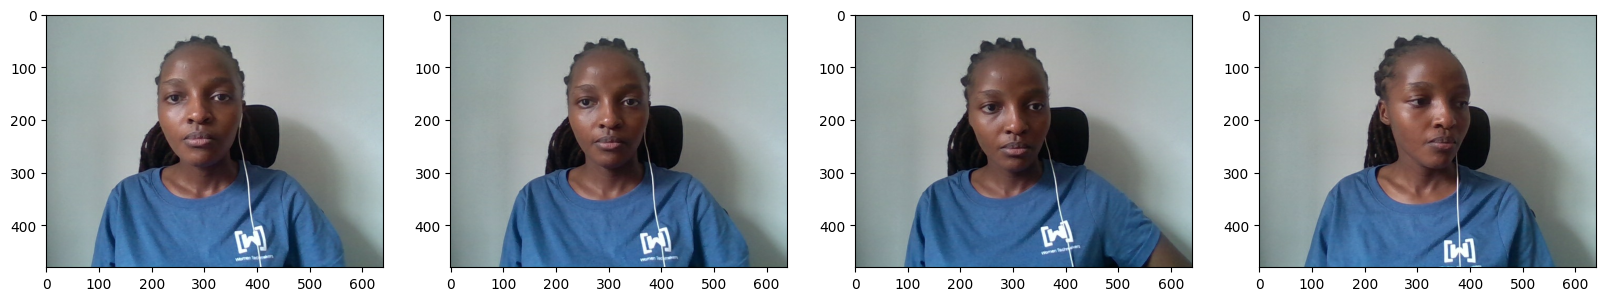

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

#### Splitting the Dataset into Test, Train and Validation Set

In [15]:
import os
import shutil

# Get the path to the data folder
data_dir = "data"

# Get the path to the images folder
images_dir = os.path.join(data_dir, "images")

# Get the list of all images in the images folder
images = os.listdir(images_dir)

# Split the images into train, test and validation sets
train_images = images[:int(len(images) * 0.6)]
test_images = images[int(len(images) * 0.6):int(len(images) * 0.8)]
validation_images = images[int(len(images) * 0.8):]

# Create the train, test and validation folders
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
validation_dir = os.path.join(data_dir, "validation")

# Create the train, test and validation subdirectories
for directory in [train_dir, test_dir, validation_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# Move the images to the train, test and validation folders
for image in train_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(train_dir, image))

for image in test_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(test_dir, image))

for image in validation_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(validation_dir, image))

### Move the Matching Labels

In [20]:
# Get the path to the labels folder
labels_dir = os.path.join(data_dir, "labels")
# Get the list of all labels in the labels folder
labels = os.listdir(labels_dir)

# Loop through the images and labels
for image in images:
    # Get the label for the image
    label = image.split(".")[0]

    # Find the label in the labels folder
    label_file = os.path.join(labels_dir, label + ".txt")

    # If the label file exists
    if os.path.exists(label_file):
        # Move the label file to the respective folder
        if image in train_images:
            shutil.move(label_file, os.path.join(train_dir, label + ".txt"))
        elif image in test_images:
            shutil.move(label_file, os.path.join(test_dir, label + ".txt"))
        else:
            shutil.move(label_file, os.path.join(validation_dir, label + ".txt"))

In [23]:
import os
import shutil

# Get the path to the data folder
data_dir = "data"

# Get the path to the images folder
images_dir = os.path.join(data_dir, "images")

# Get the path to the labels folder
labels_dir = os.path.join(data_dir, "labels")

# Get the list of all images in the images folder
images = os.listdir(images_dir)

# Split the images into train, test and validation sets
train_images = images[:int(len(images) * 0.6)]
test_images = images[int(len(images) * 0.6):int(len(images) * 0.8)]
validation_images = images[int(len(images) * 0.8):]

# Create the train, test and validation folders
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
validation_dir = os.path.join(data_dir, "validation")

# Create the train, test and validation subdirectories
for directory in [train_dir, test_dir, validation_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# Move the images to the train, test and validation folders
for image in train_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(train_dir, image))

for image in test_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(test_dir, image))

for image in validation_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(validation_dir, image))

# Find the images with similar names
similar_images = {}
for image in images:
    basename = os.path.basename(image)
    similar_images[basename] = []

# Go through the labels folder and find labels with the same name as the image
for label in os.listdir(labels_dir):
    basename = os.path.basename(label)
    if basename in similar_images:
        similar_images[basename].append(label)

# Move the labels to the respective folders
for basename, labels in similar_images.items():
    train_labels = labels[:int(len(labels) * 0.6)]
    test_labels = labels[int(len(labels) * 0.6):int(len(labels) * 0.8)]
    validation_labels = labels[int(len(labels) * 0.8):]

    train_label_dir = os.path.join(labels_dir, "train", basename)
    test_label_dir = os.path.join(labels_dir, "test", basename)
    validation_label_dir = os.path.join(labels_dir, "validation", basename)

    for label in train_labels:
        shutil.move(os.path.join(labels_dir, label), os.path.join(train_label_dir, label))

    for label in test_labels:
        shutil.move(os.path.join(labels_dir, label), os.path.join(test_label_dir, label))

    for label in validation_labels:
        shutil.move(os.path.join(labels_dir, label), os.path.join(validation_label_dir, label))


In [27]:
import os

# Get the path to the data folder
data_dir = "data"

# Get the list of all folders in the data folder
folders = os.listdir(data_dir)

# Loop over all folders
for folder in folders:

    # Get the path to the images folder in the current folder
    images_dir = os.path.join(data_dir, folder)

    # Get the list of all images in the images folder
    images = os.listdir(images_dir)

    # Loop over all images
    for image in images:

        # Get the path to the label for the current image
        label_path = os.path.join(data_dir, folder, "labels", image + ".json")

        # Check if the label exists
        if os.path.exists(label_path):

            # Get the name of the label
            label_name = os.path.basename(label_path)

            # Get the name of the image
            image_name = os.path.basename(image)

            # Check if the label name and image name are the same
            if label_name == image_name:

                # Move the label into the same folder as the image
                shutil.move(label_path, os.path.join(images_dir, label_name))
